# Импорт необходимых модулей

In [1]:
import sys
sys.path.append('..')

In [2]:
from source.code.data_loader import sample_file_addresses
from source.code.visualize import plot_word_clouds
from source.code.visualize import plot_coefficients

In [3]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from source.code.data_loader import DataLoader
from source.code.metrics import tp, tn, fp, fn

from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_curve, auc

from scipy import interp
import numpy as np

from sklearn.calibration import CalibratedClassifierCV

import matplotlib.pyplot as plt

# Описание задачи и данных

Собственно говоря, основная часть данной работы посвящена не столько детальному исследованию алгоритмов SVM-а или NB-а, сколько обработке текстов.

Был использован 
[следующий датасет](http://ai.stanford.edu/~amaas/data/sentiment/), поскольку не хотелось в работе использовать Keras только с тем, чтобы 
[выкачать его помощью данные](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification).

Данные представляют собой 25000 положительных и 25000 негативных отзывов о различных фильмах с сайта IMDb.

Папка ```./data/``` содержит файл **README**, где есть детальное описание всех имеющихся данных, поэтому здесь особо не имеет смысла повторяться.

Здесь необходимо научить алгоритм понимать по тексту эмоциональный окрас этого текста, т.е. классифицировать их как положительные или отрицательные.

In [4]:
def print_quality_metrics(pipeline):
    output = 'tp: {}, tn: {}, fp: {}, fn: {}, precision: {}, recall: {}, f1: {}'
    tp_ = tp(y_pred=pipeline.predict(X_test), y_true=y_test)
    tn_ = tn(y_pred=pipeline.predict(X_test), y_true=y_test)
    fp_ = fp(y_pred=pipeline.predict(X_test), y_true=y_test)
    fn_ = fn(y_pred=pipeline.predict(X_test), y_true=y_test)
    precision_ = round(tp_ / float(tp_ + fp_), 4)
    recall_ = round(tp_ / float(tp_ + fn_), 4)
    f1_ = round(2 * ((precision_ * recall_) / float(precision_ + recall_)), 4)
    print(output.format(tp_, tn_, fp_, fn_, precision_, recall_, f1_))

Метод
```sample_file_addresses```
просто вычитывает все имена файлов из папок

        ./data/train/pos/
        ./data/train/neg/
        ./data/test/pos/
        ./data/test/neg/
и формирует два набора адресов комментариев (позитивных и негативных).

Затем из них берется указанное количество тех и других адресов (индексы берутся из дискретного равномерного распределения), полученные наборы смешиваются и получается результирующая выборка.

In [5]:
%%time
X, y = sample_file_addresses(25000, 25000)

Wall time: 234 ms


Здесь на стратифицированной кросс-валидации тестируется линейный 
[SVM-классификатор](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC).

При этом предварительно тексты проходят через DataLoader, где происходит:
- удаление знаков препинания, HTML-тэгов, стоп-слов и т.д.
- замена сокращений типа **don't**, **won't**, **weren't** и т.д.

Также в данном классе происходит 
[лемматизация](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BC%D0%BC%D0%B0%D1%82%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F) текста и удаляются слова короче трех символов.

Выбор в сторону лемматизации, по большому счету, обусловлен тем, что стемминг не справляется в ситуациях типа was --> is, caught --> catch, что может сместить алгоритм в сторону ложных решений.

Далее каждый текст перегоняется в вектор, представляющий его в контексте частот выделенных слов, затем данные частоты инвертируются (через 
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)).

Потом обучается классификатор, для него считаются метрики и выводятся в sdtout, затем выводится график
[AUC-ROC](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py).

Стоит отметить, что для того, чтобы можно было посчитать AUC-ROC, необходимо было задействовать 
[CalibratedClassifierCV](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html)
с тем, чтобы SVM-классификатор мог выдавать вероятности классов.

Подробнее процесс калибрации вероятности описан [здесь](http://scikit-learn.org/stable/modules/calibration.html#calibration).

In [6]:
MEDIUM_SIZE = 30
BIGGER_SIZE = 50

plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=MEDIUM_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)
plt.rc('text', color='green')

plt.rc('xtick', color='green')
plt.rc('ytick', color='green')

plt.rc('axes', labelcolor='green')
plt.rc('axes', labelcolor='green')

tp: 5951, tn: 5924, fp: 299, fn: 326, precision: 0.9522, recall: 0.9481, f1: 0.9501
tp: 5962, tn: 5918, fp: 288, fn: 332, precision: 0.9539, recall: 0.9473, f1: 0.9506
tp: 6005, tn: 5936, fp: 245, fn: 314, precision: 0.9608, recall: 0.9503, f1: 0.9555
tp: 5960, tn: 5916, fp: 290, fn: 334, precision: 0.9536, recall: 0.9469, f1: 0.9502


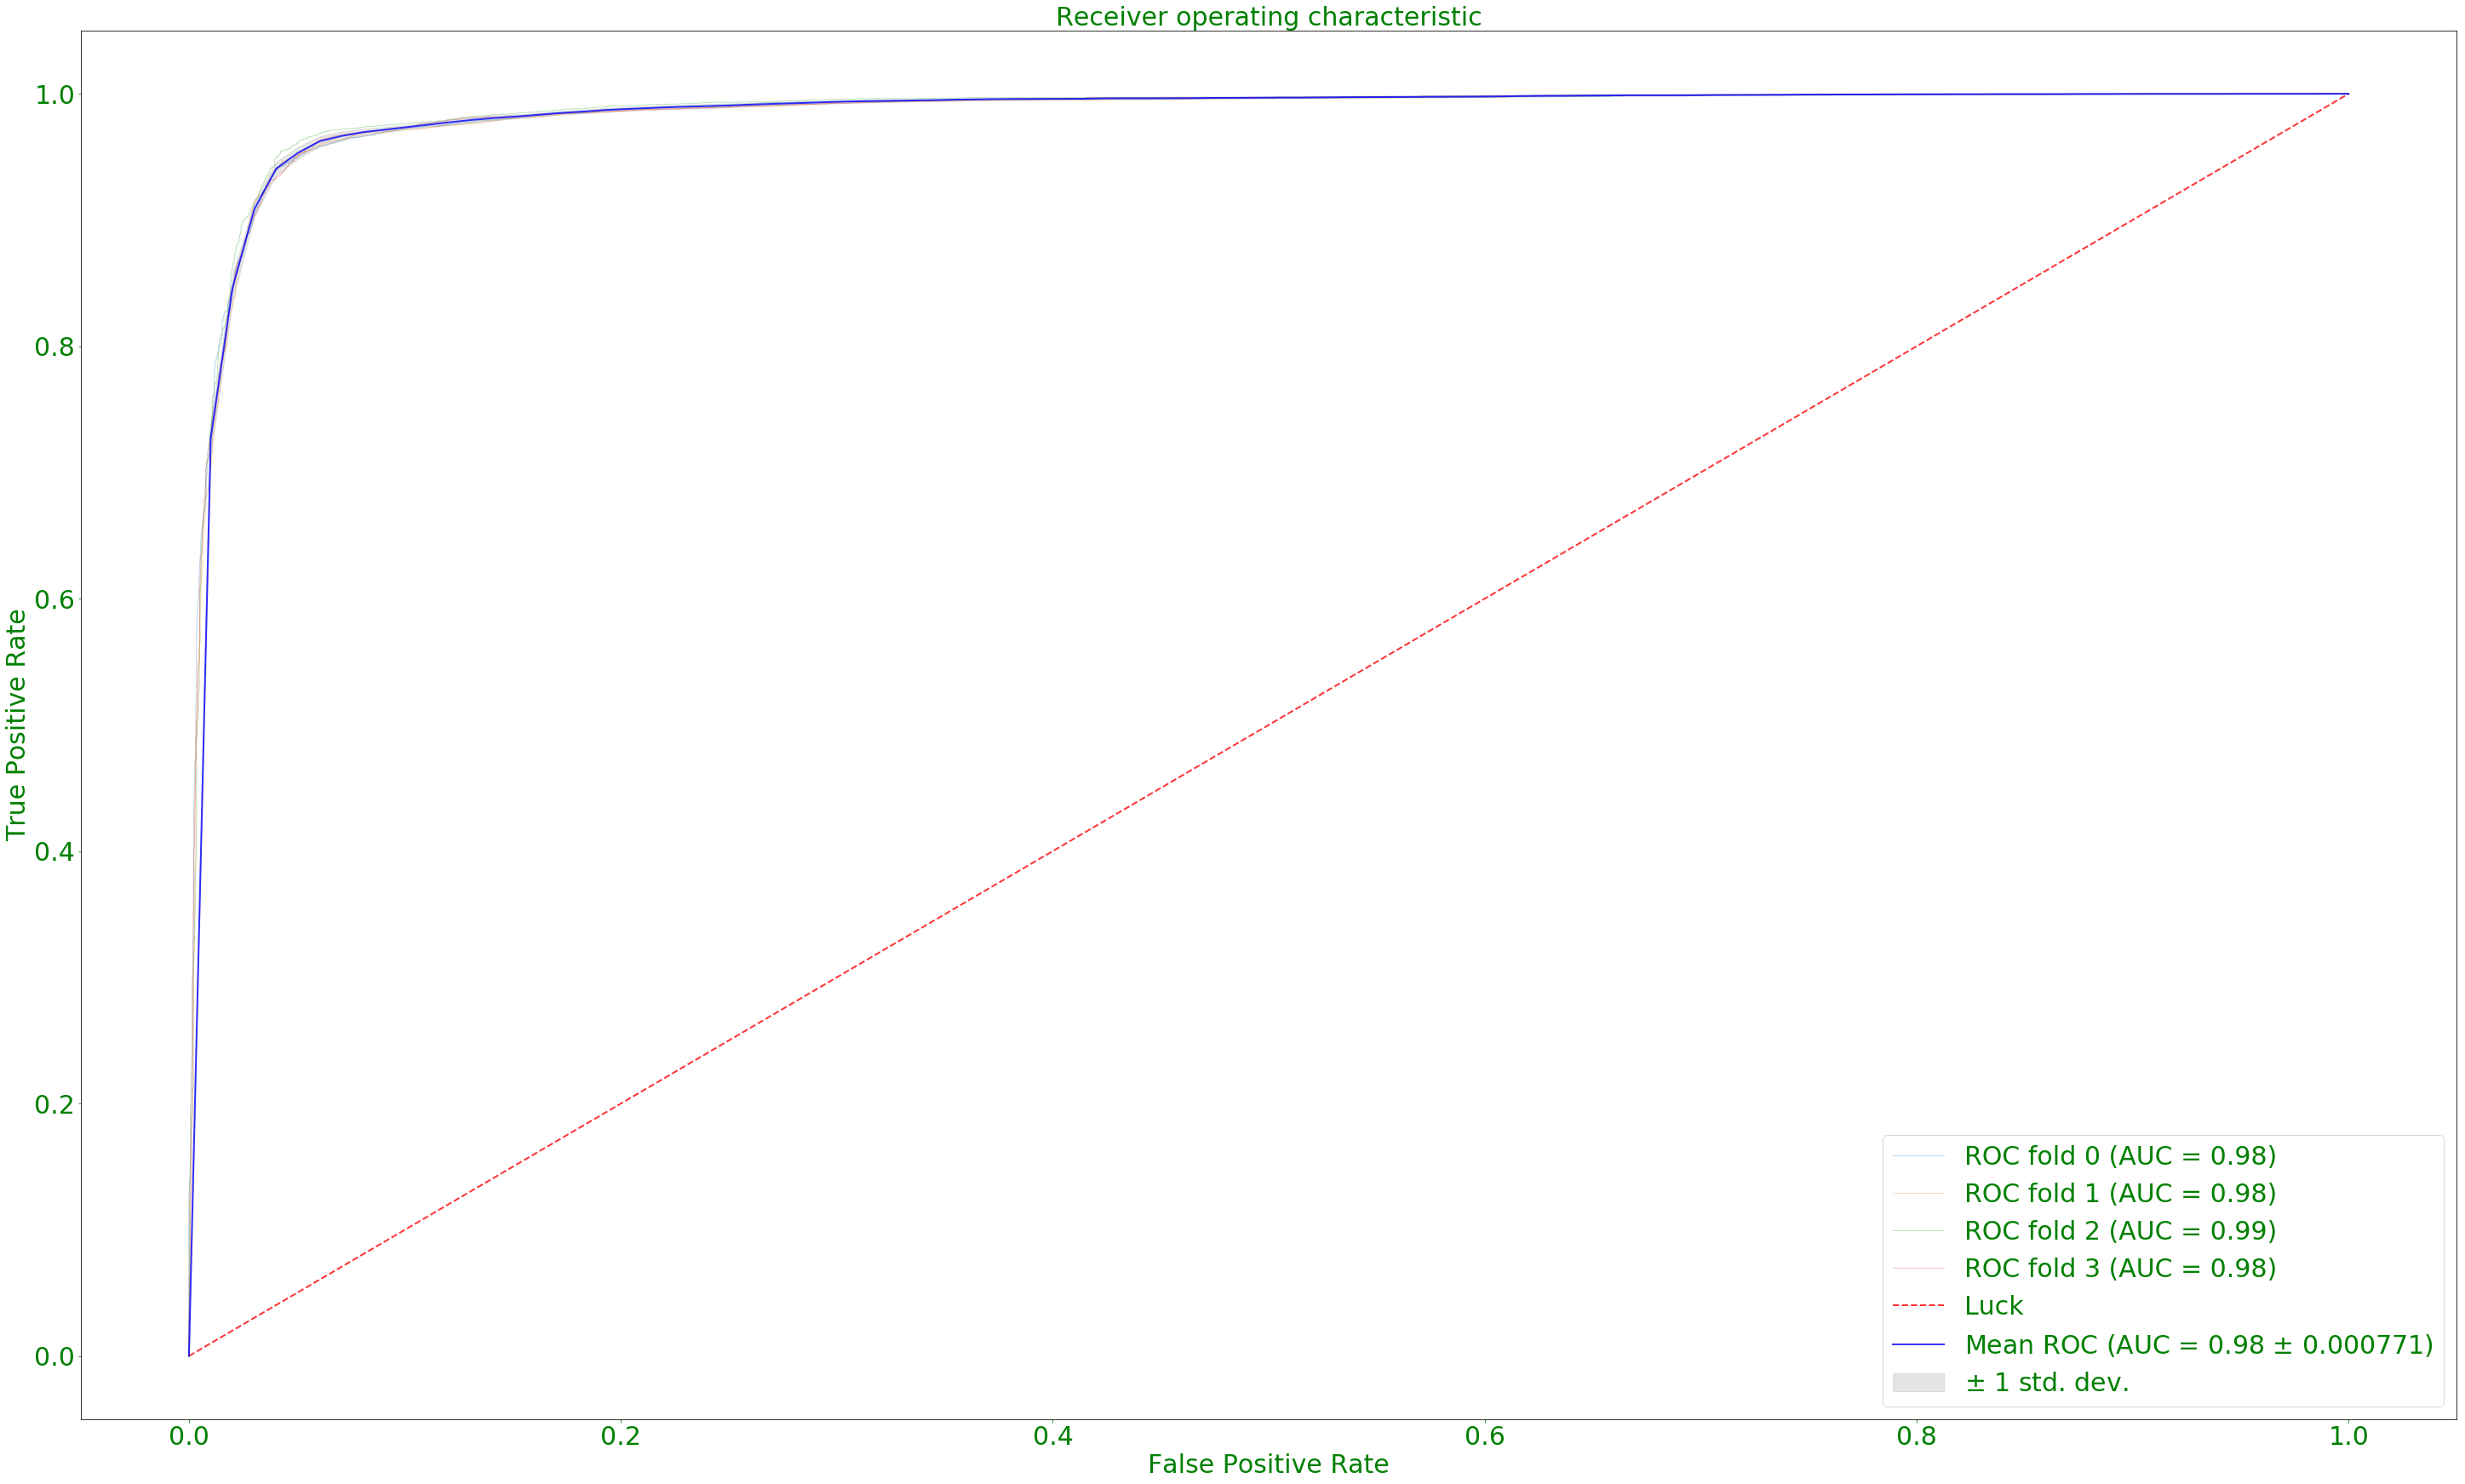

Wall time: 23min 21s


In [7]:
%%time
skf = StratifiedKFold(n_splits=4)
pipeline_results = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
plt.figure(figsize=(50, 30))
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pipeline = Pipeline([
        ('load', DataLoader()),
        ('vectorize', CountVectorizer(ngram_range=(1, 2))),
        ('inverse', TfidfTransformer(smooth_idf=True)),
        ('fit', CalibratedClassifierCV(LinearSVC()))
    ])
    pipeline.fit(X_train, y_train)
    pipeline_results.append(pipeline)
    print_quality_metrics(pipeline)
    
    fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.6f)' % (mean_auc, std_auc), lw=2, alpha=0.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Судя по графику линейный SVM-классификатор показывает очень хорошее качество.

Площадь под ROC-кривой в среднем занимает 98% единичного квадрата, что гораздо лучше случайного угадывания.

Попробуем теперь глянуть на значимость слов и словосочетаний, фигурирующих в текстах.

Для этого заново обучим классификатор, а затем для каждого сплита выведем слова/словосочетания и соответствующие им веса.

Положительные веса обозначим синим цветом, отрицательные - красным.

In [8]:
%%time
skf = StratifiedKFold(n_splits=4)
pipeline_results_1 = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pipeline = Pipeline([
        ('load', DataLoader()),
        ('vectorize', CountVectorizer(ngram_range=(1, 2))),
        ('inverse', TfidfTransformer(smooth_idf=True)),
        ('fit', LinearSVC())
    ])
    pipeline.fit(X_train, y_train)
    pipeline_results_1.append(pipeline)
    print_quality_metrics(pipeline)

tp: 5977, tn: 5903, fp: 273, fn: 347, precision: 0.9563, recall: 0.9451, f1: 0.9507
tp: 5985, tn: 5907, fp: 265, fn: 343, precision: 0.9576, recall: 0.9458, f1: 0.9517
tp: 6025, tn: 5934, fp: 225, fn: 316, precision: 0.964, recall: 0.9502, f1: 0.9571
tp: 5986, tn: 5918, fp: 264, fn: 332, precision: 0.9578, recall: 0.9475, f1: 0.9526
Wall time: 19min 44s


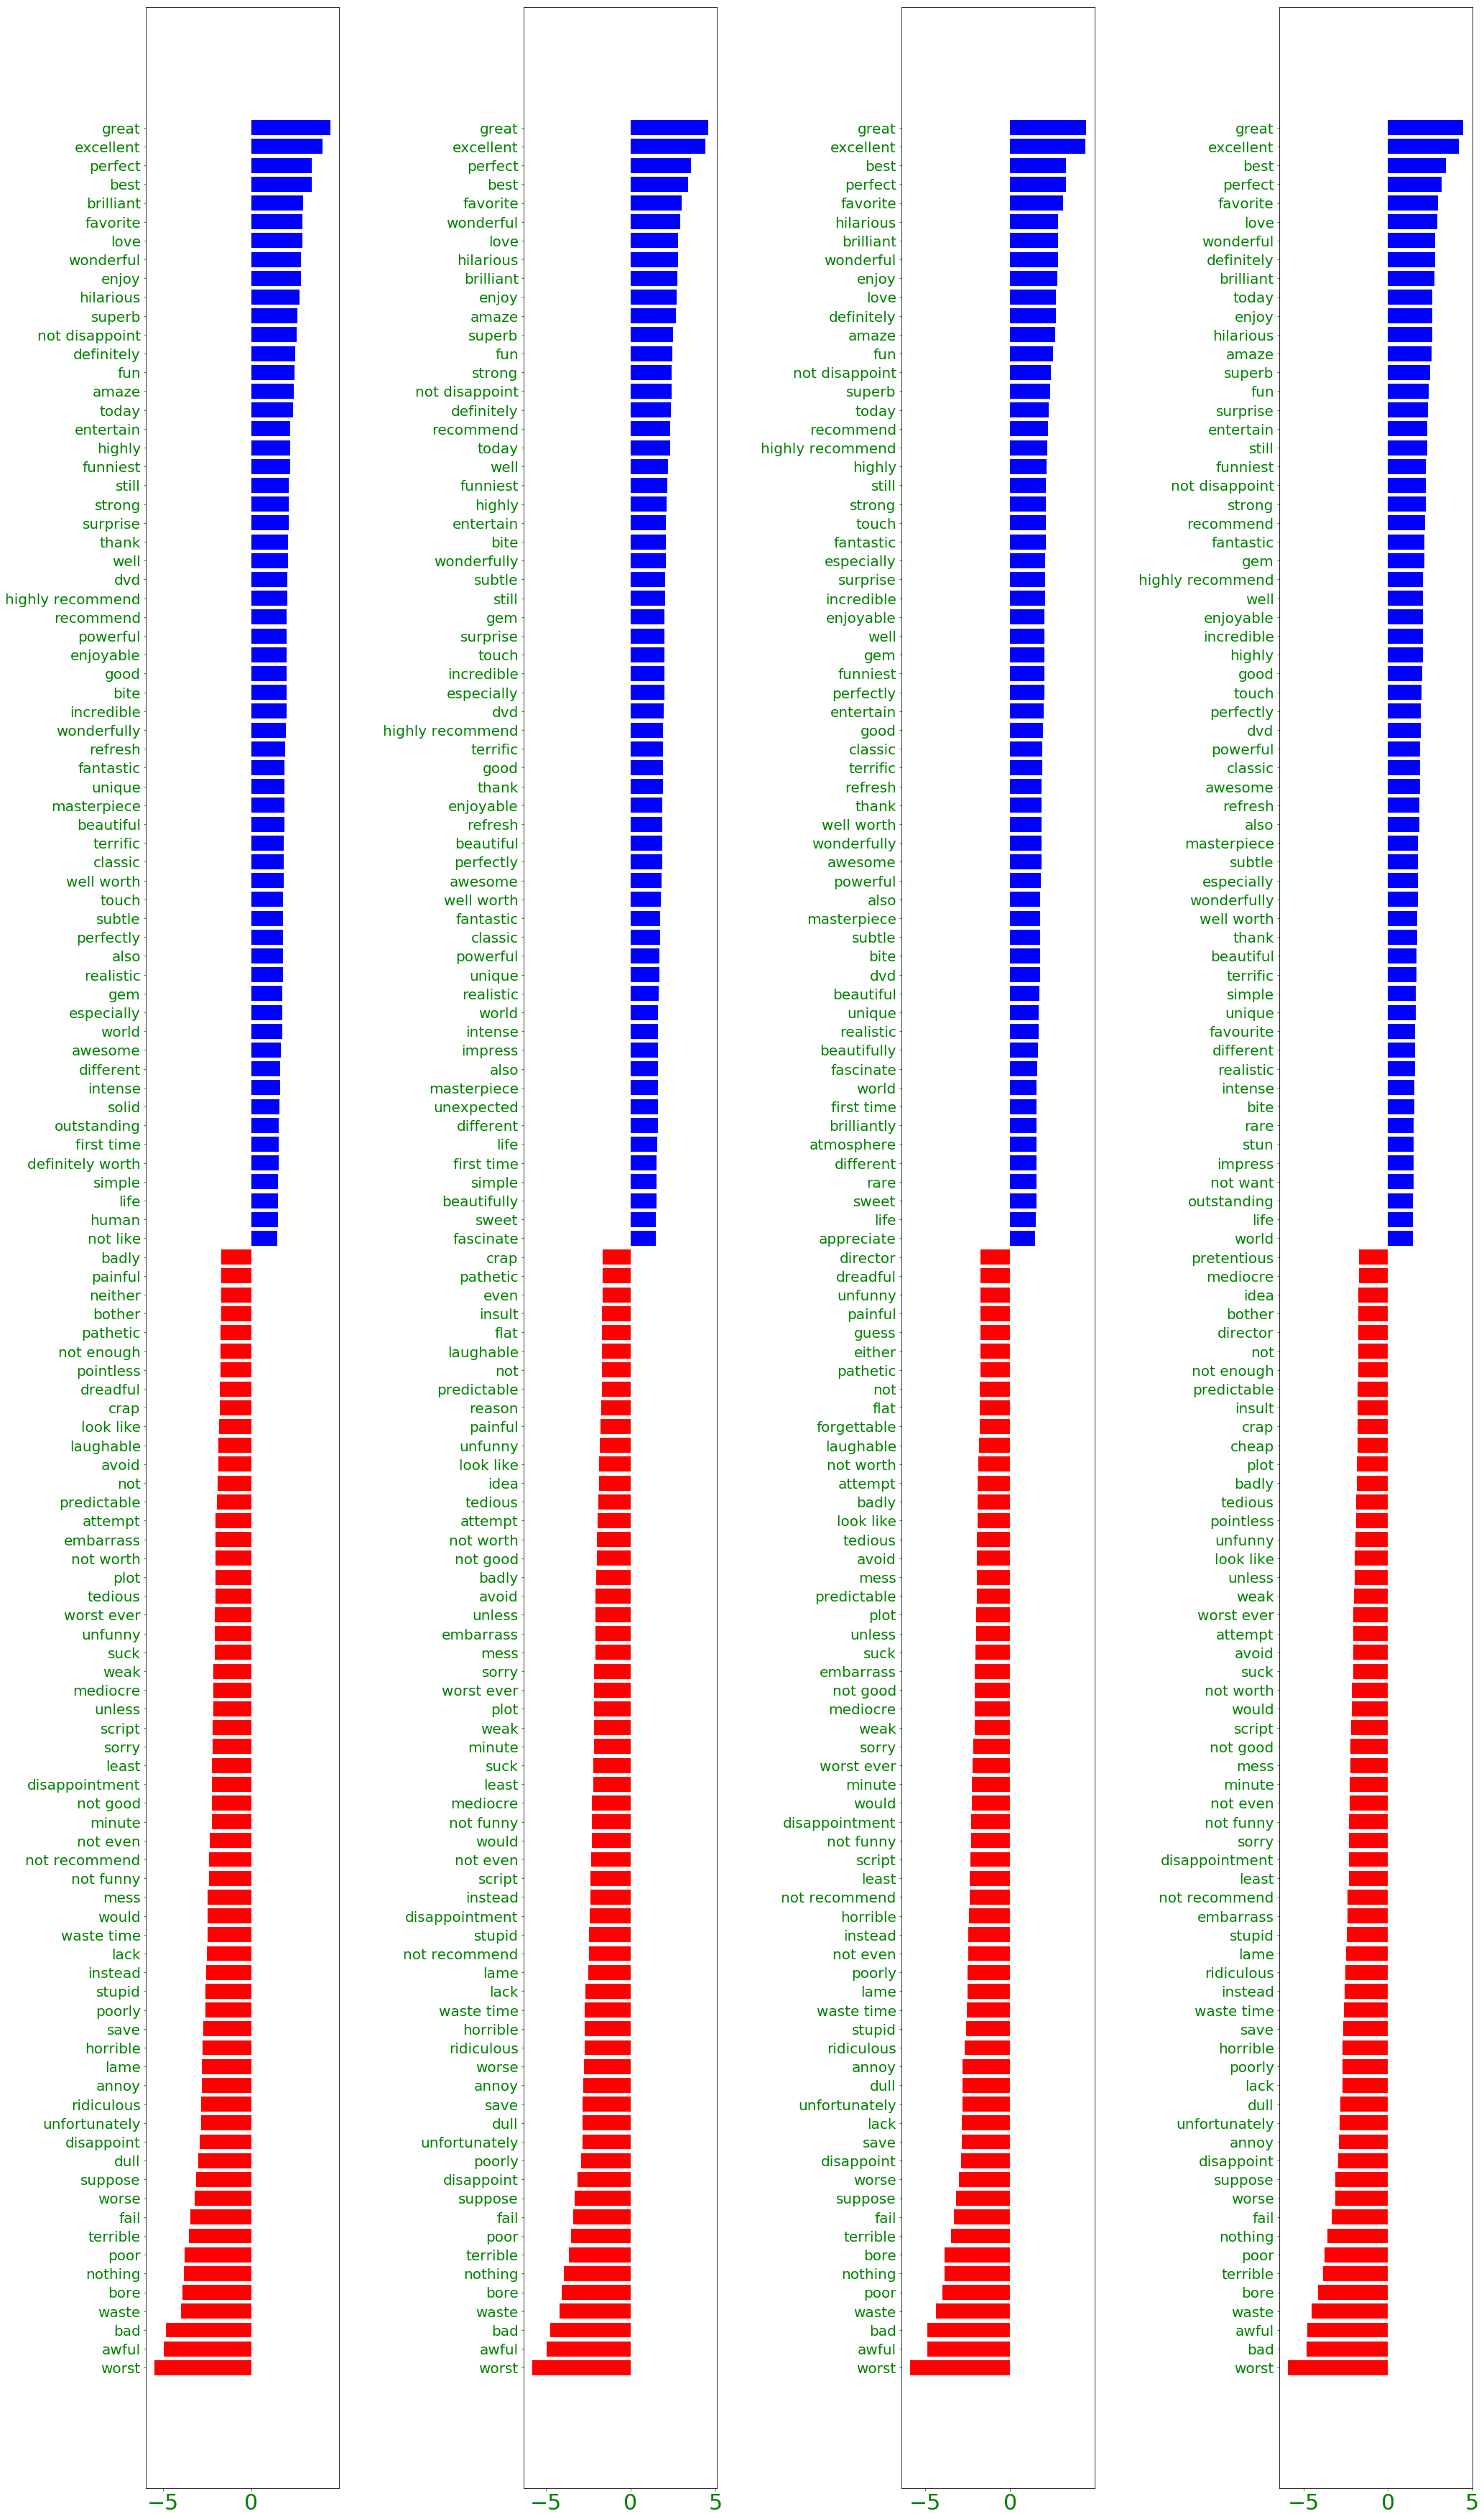

In [9]:
plot_coefficients(
    list(map(lambda x: x.get_params()['fit'], pipeline_results_1)),
    list(map(lambda x: x.get_params()['vectorize'].get_feature_names(), pipeline_results_1)),
    top_features=60
)

Судя по графикам картина довольно логичная.

В целом алгоритм выделил слова, несущие сильный негативный (worst, awful, bad, terrible и т.д.) и позитивный (great, excellent, best и т.д.) окрас.

Стоит отметить, что присутствуют также слова, которые могли с одинаковым успехом оказаться в любых комментариях, однако таких слов не так уж и много и они не расположены в первых рядах (по крайней мере в топ-10 такие слова не входят).

Помимо построения диаграмм вида топ-[сколько-то там] слов можно также построить облака слов.

Для этого используется библиотека 
[WordCloud](https://github.com/amueller/word_cloud).

Ее особенность в том, что она принимает на вход текст, затем дробит его на токены, группирует по частоте и, собственно, формирует облака в зависимости от этих частот.

Проблема в том, что в нашем случае есть слова и соответствующие им веса, но нет текста.

Это решается тем, что веса просто домножаются на 1000 (произвольный выбор), берется целая часть, а затем генерируется массив слов, где каждое слово повторяется количество раз, равное этой самой целой части.

Массив объединается в одну строку, передается в метод библиотеки, который генерит картинку и, собственно, на этом все.

Получается довольно хорошее отображение, за исключением того, здесь не учитывается вклад словосочетаний (это обусловлено тем, что когда мы соединяем отдельные повторения слов и словосочетаний в одну строку, мы теряем информацию о том, что было отдельным словом, а что - словосочетанием).

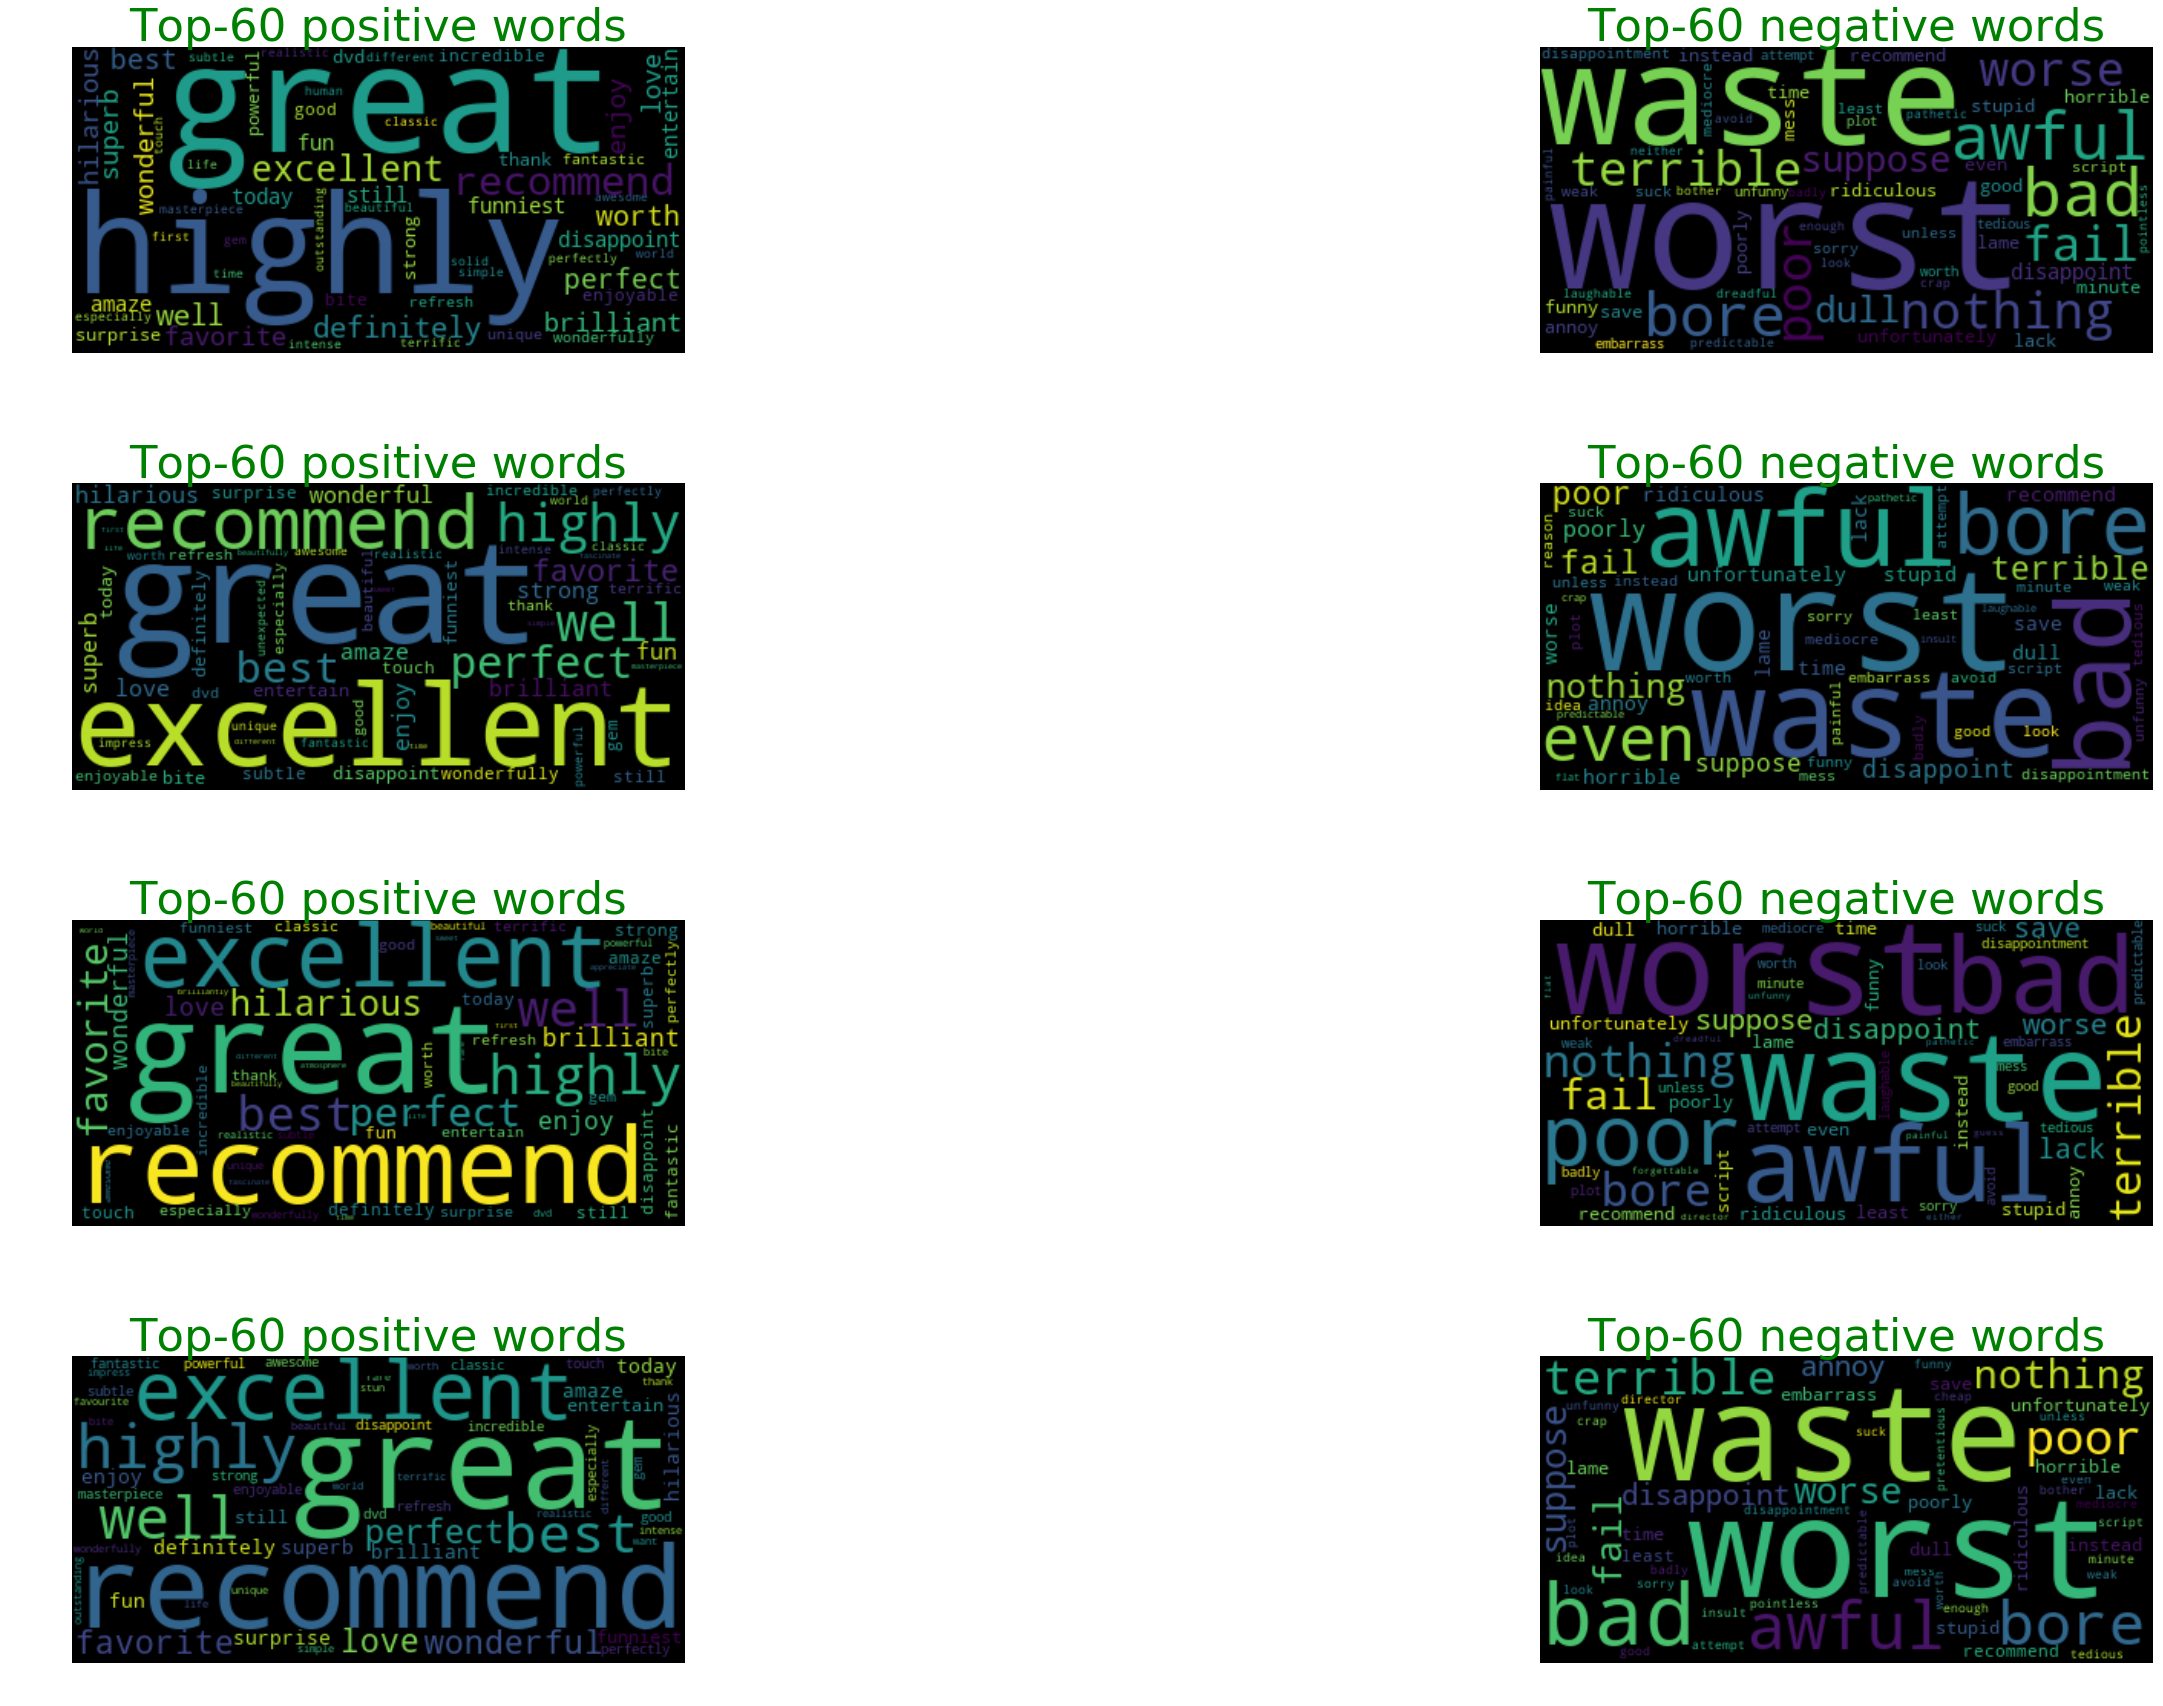

In [10]:
plot_word_clouds(
    list(map(lambda x: x.get_params()['fit'], pipeline_results_1)),
    list(map(lambda x: x.get_params()['vectorize'].get_feature_names(), pipeline_results_1)),
    top_features=60
)

Здесь на стратифицированной кросс-валидации тестируется 
[наивный байесовский классификатор](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB).

В данной задаче не используется оптимизация гиперпараметров (по большому счету из-за экономии времени и того, что и без оптимизации алгоритмы показали довольно хорошее качество).

Все процедуры, касающиеся обработки текста здесь идентичны тем, что производились для линейного SVM-а.

tp: 5812, tn: 5880, fp: 438, fn: 370, precision: 0.9299, recall: 0.9401, f1: 0.935
tp: 5823, tn: 5903, fp: 427, fn: 347, precision: 0.9317, recall: 0.9438, f1: 0.9377
tp: 5839, tn: 5909, fp: 411, fn: 341, precision: 0.9342, recall: 0.9448, f1: 0.9395
tp: 5833, tn: 5883, fp: 417, fn: 367, precision: 0.9333, recall: 0.9408, f1: 0.937


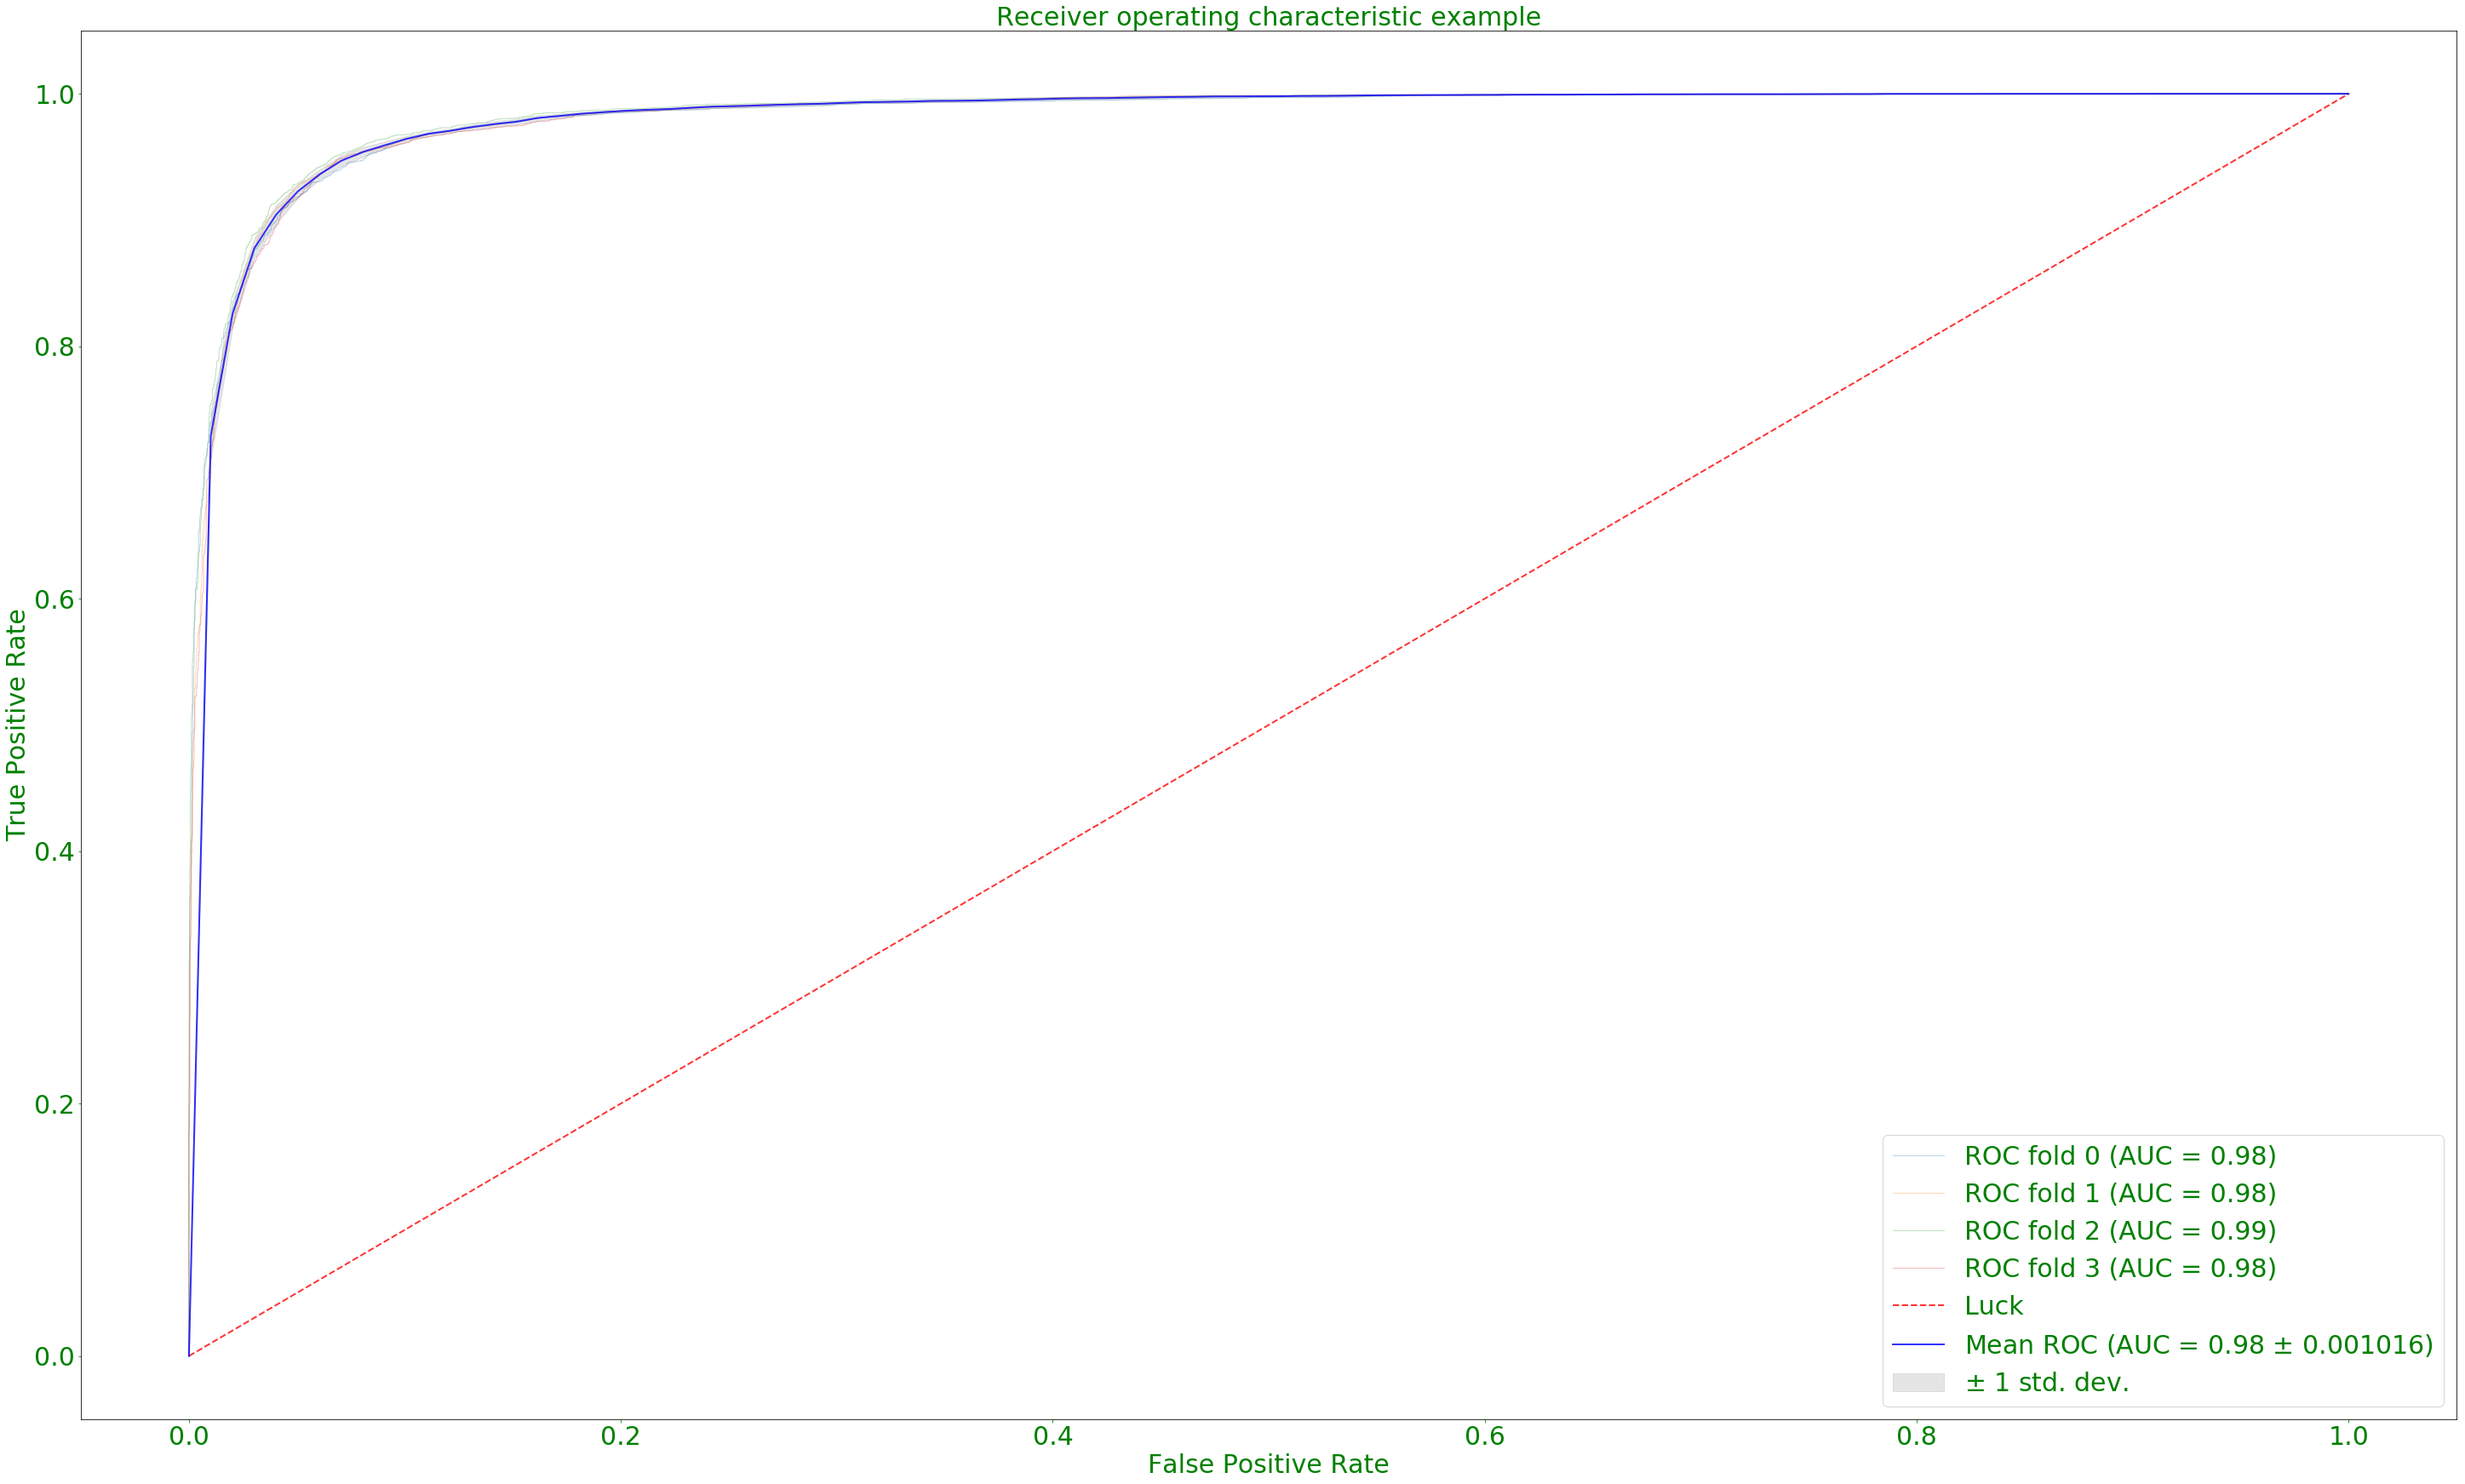

Wall time: 22min 42s


In [11]:
%%time
skf = StratifiedKFold(n_splits=4)
pipeline_results = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
plt.figure(figsize=(50, 30))
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pipeline = Pipeline([
        ('load', DataLoader()),
        ('vectorize', CountVectorizer(ngram_range=(1, 2))),
        ('inverse', TfidfTransformer(smooth_idf=True)),
        ('fit', MultinomialNB())
    ])
    pipeline.fit(X_train, y_train)
    pipeline_results.append(pipeline)
    print_quality_metrics(pipeline)
    
    fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.6f)' % (mean_auc, std_auc), lw=2, alpha=0.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Как и в первом случае MultinomialNB (MNB) дал довольно высокое качество, покрыв примерно 98% площади единичного квадрата.

Стоит все же отметить, что значения точности и полноты в целом для MNB ниже, чем для линейного SVM.

# Заключение

Итак, в данной работе были использованы:
- Linear Support vector machine classifier;
- Multinomial Naive Bayes classifier.

Для их использования была проведена предварительная обработка текстов, а именно:
- Удаление мусорных символов (HTML-тэги, знаки препинания);
- Замена сокращений вида don't, won't, haven't на их полные формы;
- фильтрация стоп-слов типа the, is etc.;
- лемматизация слов;
- фильтрация слов короче 3 символов;
- расчет векторов количеств вхождений слов в текст:
- TF-IDF.

Стоит отметить, что из списка стоп-слов было исключено слово 'not', что позволило выхватить словосочетания типа 'not good', 'not worth', 'not recommend' и т.д.

Врочем наряду с этим отдельное слово 'not' тоже попало в топ-60 негативных слов, хотя само по себе не несет ни положительного, ни отрицательного окраса.

То, что могло бы повысить качество классификации:
- **тюнинг гиперпараметров**. Здесь он не производится в целях экономии времени и потому, что достигнутое качество позволяет сильно не изощряться (впрочем, все зависит от четкости и жесткости критериев);
- **использование skip-грамм**. В данной работе при токенизации использовались униграммы и биграммы, хотя можно было бы также задействовать N-граммы более высоких порядков и так называемые 
[skip-граммы](https://en.wikipedia.org/wiki/N-gram#Skip-gram).
- **использование более продвинутых техник** (Word2Vec).